In [1]:
import os, sys, pickle
%pylab inline
plt.style.use("default")

Populating the interactive namespace from numpy and matplotlib


In [2]:
base_dir = os.path.split(os.getcwd())[0]
print(base_dir)
sys.path.append(base_dir)

/camp/lab/schaefera/working/tootoos/git/crick-osn-model-release


In [3]:
from classify import get_output_root, confusion_matrix_as_ranks

In [4]:
osn_dataset = "gamp5"
params      = "ncv40"
prefix = os.path.join(get_output_root(osn_dataset), params) + "/"
files = {"conc":f"{prefix}conc_orig.p",
         "conc_shuf":f"{prefix}conc_shuf.p",
         "ppi.conc":f"{prefix}ppi.conc_orig.p",
         "ppi.conc_shuf":f"{prefix}ppi.conc_shuf.p"
}
def load_file(f):
    with open(f,"rb") as ff:
        return pickle.load(ff)

data = {fld:load_file(fl) for fld, fl in files.items()}

# Plot the distribution of responses at each concentration

In [5]:
ppi_concs = data["ppi.conc"]["labels"]
X     = data["ppi.conc"]["X"]
y     = data["ppi.conc"]["y"]
concs = sorted(list(set(yi.split(".")[1] for yi in y)))
resps = {10:array([X[array(y)==f"10.{int(c):03d}"].flatten() for c in concs]).T,
         25:array([X[array(y)==f"25.{int(c):03d}"].flatten() for c in concs]).T}

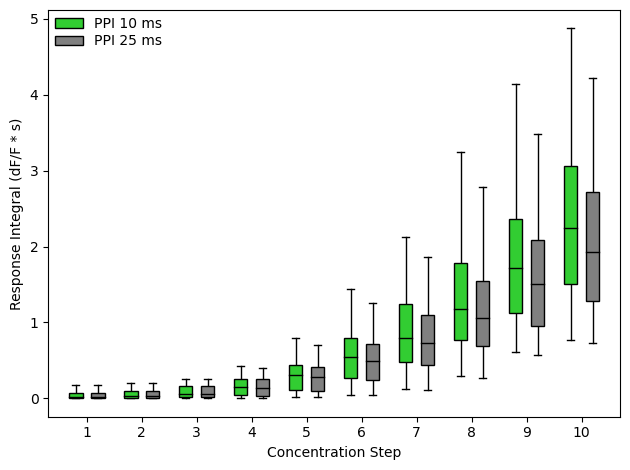

In [6]:
centers= arange(len(concs))
bplots = []
for (ppi, color, offset) in [(10, "limegreen", -0.2), (25, "gray", 0.2)]:
    pos   = centers + offset
    bplots.append(boxplot(resps[ppi], showfliers=False, patch_artist = True, medianprops={"color":"black", "linewidth":1}, positions=pos, widths=0.25, whis=[5,95]))
    [b.set_facecolor(color) for b in bplots[-1]["boxes"]]
gca().set_xticks(centers)
gca().set_xticklabels(arange(1,len(concs)+1))
xlabel("Concentration Step"); ylabel("Response Integral (dF/F * s)")
legend([bp["boxes"][0] for bp in bplots],["PPI 10 ms", "PPI 25 ms"], loc="upper left", labelspacing=0.25,frameon=False, borderpad=0)
tight_layout()
savefig("response_integrals_per_conc.pdf", bbox_inches="tight")

# Plot confusion matrices

In [7]:
print1    = lambda x: int(x) if not np.isnan(x) else ""
label_cm  = lambda cm,th,fsz=10,cols="wk": [text(j,i, print1(cm[i,j]),fontsize=fsz,verticalalignment="center", horizontalalignment="center", color=cols[0] if cm[i,j] > th else cols[1]) if cm[i,j] else [] for j in range(cm.shape[1]) for i in range(cm.shape[0])]
set_ticks = lambda labs: [(ticks_fun(arange(len(labs))), tickslabel_fun(labs)) for (ticks_fun, tickslabel_fun) in [(gca().set_xticks, gca().set_xticklabels), (gca().set_yticks, gca().set_yticklabels)]]
def plot_confusion_matrix(cm, labs, th = 0, ranks = False, max_rank=np.inf, fsz=12, **kwargs):
    vals = confusion_matrix_as_ranks(cm) if ranks else copy(cm)
    vals = vals.astype(float)
    if ranks:
        vals[vals>max_rank] = nan
    matshow(vals, **kwargs)
    set_ticks(labs)
    label_cm(vals, th, fsz=fsz, cols="kw")

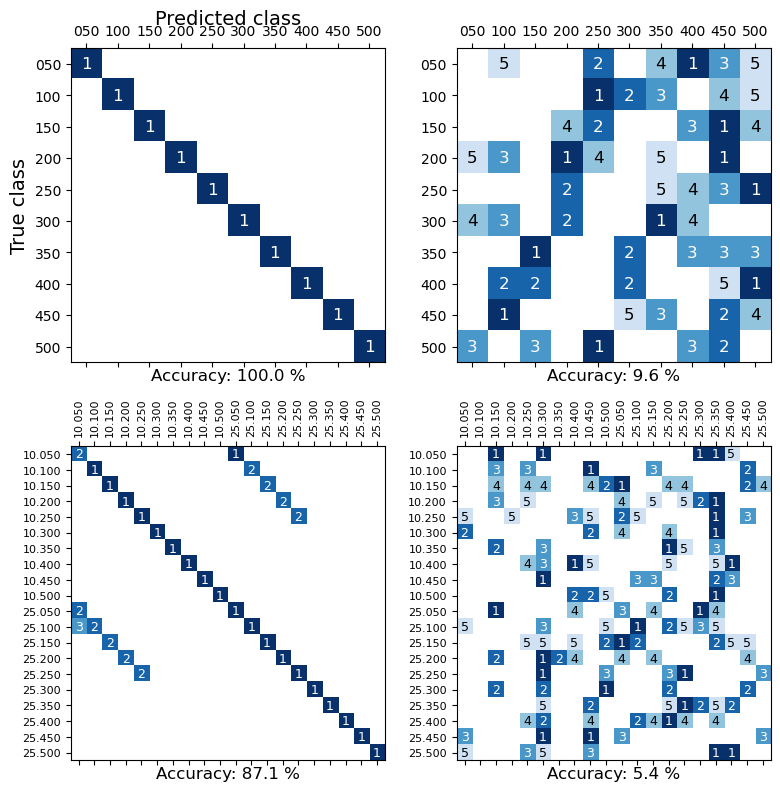

In [8]:
# Now the confusion matrix for concentration
acc_from_cm = lambda cm: trace(cm)/sum(cm)
figure(figsize=(8,8))
cm_conc   = data["conc"]["confusion_matrix"]
subplot(2,2,1); plot_confusion_matrix(data["conc"]["confusion_matrix"],       concs, th = 3, ranks=True, cmap=cm.Blues_r, vmin=1,vmax=6, max_rank=5, fignum=False);
title("Predicted class", fontsize=14); ylabel("True class", fontsize=14); xlabel("Accuracy: {:1.1f} %".format(acc_from_cm(data["conc"]["confusion_matrix"])*100), fontsize=12)
subplot(2,2,2); plot_confusion_matrix(data["conc_shuf"]["confusion_matrix"],  concs, th = 3, ranks=True, cmap=cm.Blues_r, vmin=1,vmax=6, max_rank=5, fignum=False);
xlabel("Accuracy: {:1.1f} %".format(acc_from_cm(data["conc_shuf"]["confusion_matrix"])*100), fontsize=12)

subplot(2,2,3); plot_confusion_matrix(data["ppi.conc"]["confusion_matrix"], ppi_concs, fsz = 9, th = 3, ranks=True, cmap=cm.Blues_r, vmin=1,vmax=6, max_rank=5, fignum=False)
gca().set_xticks(arange(len(ppi_concs))); gca().set_xticklabels(ppi_concs,fontsize=8, rotation=90)
gca().set_yticks(arange(len(ppi_concs))); gca().set_yticklabels(ppi_concs,fontsize=8)
xlabel("Accuracy: {:1.1f} %".format(acc_from_cm(data["ppi.conc"]["confusion_matrix"])*100), fontsize=12)

subplot(2,2,4); plot_confusion_matrix(data["ppi.conc_shuf"]["confusion_matrix"], ppi_concs, fsz = 9, th = 3, ranks=True, cmap=cm.Blues_r, vmin=1,vmax=6, max_rank=5, fignum=False)
gca().set_xticks(arange(len(ppi_concs))); gca().set_xticklabels(ppi_concs,fontsize=8, rotation=90)
gca().set_yticks(arange(len(ppi_concs))); gca().set_yticklabels(ppi_concs,fontsize=8)
xlabel("Accuracy: {:1.1f} %".format(acc_from_cm(data["ppi.conc_shuf"]["confusion_matrix"])*100), fontsize=12)
tight_layout()
savefig("confusion_matrices.pdf", bbox_inches="tight")